# **Aim:**
This project is to explore and implement two distinct deep learning approaches VGG-based image colorization and GAN-based image colorization to convert grayscale images into visually realistic color images. The project evaluates and compares the performance of each approach to understand their strengths and limitations in the context of image colorization.

In [1]:
from tensorflow.keras.layers import Conv2D, UpSampling2D, Input
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from skimage.color import rgb2lab, lab2rgb, gray2rgb
from skimage.transform import resize
from skimage.io import imsave
import numpy as np
import tensorflow as tf
import os


#  VGG Model



*   To leverage a pretrained VGG model as a feature extractor, using transfer learning to apply high-level feature representations for accurate color prediction.
*   By focusing on extracting semantic features, the VGG model can help produce more contextually aware colorizations, especially for recognizable objects like landscapes, faces, and buildings.



In [2]:
from keras.applications.vgg16 import VGG16

vggmodel = VGG16()

newmodel = Sequential()


553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 25s 0us/step


In [3]:
vggmodel.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc1 (Dense)                          │ (None, 4096)                │     102,764,544 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 138,357,544 (527.79 MB)

 Trainable params: 138,357,544 (527.79 MB)

 Non-trainable params: 0 (0.00 B)

In [4]:
# Iterate through the layers of the VGG16 model.
# Include only the first 19 layers for feature extraction.
for i, layer in enumerate(vggmodel.layers):
    if i < 19:
        newmodel.add(layer)


newmodel.summary()

# Set all layers in the new model to be non-trainable to retain pre-trained weights.
for layer in newmodel.layers:
    layer.trainable = False

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

Loading of dataset
Training: Approximately 7,000 RGB images
Testing: 5 grayscale images

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
!unzip /content/drive/MyDrive/training.7z

Archive:  /content/drive/MyDrive/training.7z
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of /content/drive/MyDrive/training.7z or
        /content/drive/MyDrive/training.7z.zip, and cannot find /content/drive/MyDrive/training.7z.ZIP, period.


In [7]:
!apt-get install -y p7zip-full


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
p7zip-full is already the newest version (16.02+dfsg-8).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


In [8]:
!7z x /content/drive/MyDrive/training.7z -o/content/drive/MyDrive/training_data



7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan /content/drive/MyDrive/                                 1 file, 98741930 bytes (95 MiB)

Extracting archive: /content/drive/MyDrive/training.7z
--
Path = /content/drive/MyDrive/training.7z
Type = 7z
Physical Size = 98741930
Headers Size = 49625
Method = LZMA2:26
Solid = +
Blocks = 1

  0%      0% 1 - training/color                         3% 2      
Would you like to replace the existing file:
  Path:     /content/drive/MyDrive/training_data/training/color/0.jpg
  Size:     13527 bytes (14 KiB)
  Modified: 2021-09-02 05:22:12
with the file from archive:
  Path:     training/color/0.jpg
  Size:     13527 bytes (14 KiB)
 

In [9]:
#Image Preprocessing and Normalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255)

ROOT_DIR = '/content/drive/MyDrive/training_data'


train = train_datagen.flow_from_directory(
    ROOT_DIR,
    target_size=(224, 224),  # Resizes all images to 224x224 pixels
    batch_size=1000,
    class_mode=None  # Set to None for data loading without class labels
)


Found 7051 images belonging to 1 classes.


In [35]:
import numpy as np
from skimage.color import rgb2lab
# Convert from RGB to Lab: LAB image is a grayscale image in L channel and all color info stored in A and B channels
X = []
Y = []


for img in train[0]:
    try:

        lab = rgb2lab(img)


        X.append(lab[:, :, 0])

        # Extract the A and B channels (color information) and normalize the values
        # A and B values range from -127 to 128, so we divide the values by 128 to restrict them to the range between -1 and 1
        Y.append(lab[:, :, 1:] / 128)
    except:

        print('Error processing an image.')


X = np.array(X)
Y = np.array(Y)

# Add an additional channel to the grayscale images to make their dimensions compatible with the color channels
X = X.reshape(X.shape + (1,))


print(X.shape)
print(Y.shape)

(1000, 224, 224, 1)
(1000, 224, 224, 2)


These extracted features will help the colorization model by providing contextual information about objects and patterns in each grayscale image, aiding the color prediction for each part of the image.

In [11]:


vggfeatures = []


for i, sample in enumerate(X):

    sample = gray2rgb(sample)
    sample = sample.reshape((1, 224, 224, 3))
    prediction = newmodel.predict(sample)
    prediction = prediction.reshape((7, 7, 512)) #gives a compact yet detailed representation of the image’s content and structure,This feature map serves as a powerful input for
                                                 #the colorization model, helping it to predict colors based on high-level contextual information.
    vggfeatures.append(prediction)


vggfeatures = np.array(vggfeatures)

print(vggfeatures.shape)


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense,UpSampling2D


model = Sequential()
model.add(Conv2D(256, (3, 3), activation='relu', padding='same', input_shape=(7, 7, 512)))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))

# Add an upsampling layer to increase the spatial resolution by a factor of 2
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(2, (3, 3), activation='tanh', padding='same'))
model.add(UpSampling2D((2, 2)))

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 7, 7, 256)           │       1,179,904 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 7, 7, 128)           │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d (UpSampling2D)         │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 14, 14, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_1 (UpSampling2D)       │ (None, 28, 28, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 28, 28, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_2 (UpSampling2D)       │ (None, 56, 56, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 56, 56, 16)          │           4,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_3 (UpSampling2D)       │ (None, 112, 112, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 112, 112, 2)         │             290 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_4 (UpSampling2D)       │ (None, 224, 224, 2)         │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,572,114 (6.00 MB)

 Trainable params: 1,572,114 (6.00 MB)

 Non-trainable params: 0 (0.00 B)

In [38]:

# Compile the model using the Adam optimizer, mean squared error loss, and accuracy metric
model.compile(optimizer='Adam', loss='mse', metrics=['accuracy'])

# Train the model using VGG features and Y data
history=model.fit(vggfeatures, Y, verbose=1, epochs=100, batch_size=32, validation_split=0.2)

Epoch 1/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 74ms/step - accuracy: 0.8612 - loss: 0.0016 - val_accuracy: 0.8335 - val_loss: 0.0025
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.8785 - loss: 0.0012 - val_accuracy: 0.8368 - val_loss: 0.0023
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.8796 - loss: 0.0011 - val_accuracy: 0.8367 - val_loss: 0.0023
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.8829 - loss: 0.0010 - val_accuracy: 0.8360 - val_loss: 0.0023
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.8882 - loss: 0.0011 - val_accuracy: 0.8371 - val_loss: 0.0023
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.8843 - loss: 0.0010 - val_accuracy: 0.8374 - val_loss: 0.0023
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.8833 - loss: 0.0010 - val_accuracy: 0.8375 - val_loss: 0.0023
Epoch 8/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.8803 - loss: 0.0010 - val_accuracy: 0.

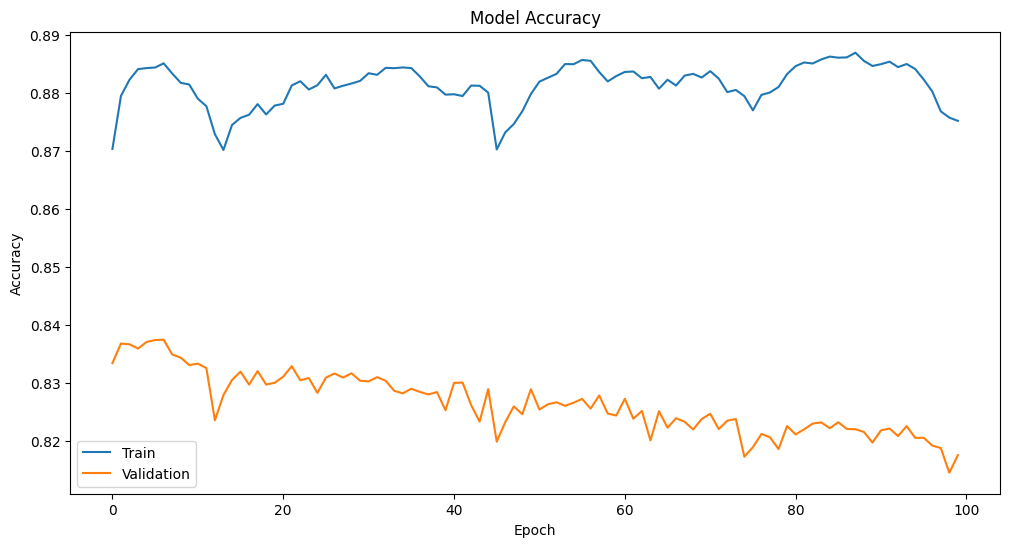

In [39]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])



1. **High Training Accuracy**: The model achieves high accuracy on the training data (around 87-89%).

2. **Low Validation Accuracy**: Validation accuracy remains low (around 32-34%) throughout, indicating poor generalization.

3. **Large Gap Between Training and Validation Accuracy**: This significant gap suggests overfitting to the training data.

4. **No Improvement in Validation Accuracy**: Validation accuracy stays flat, showing that the model fails to learn patterns that generalize to new data.

5. **Possible Solutions**:
   - Use regularization (e.g., dropout).
   - Simplify the model architecture.
   - Gather more data

In [18]:
!unzip /content/drive/MyDrive/test.zip

Archive:  /content/drive/MyDrive/test.zip
   creating: test/
  inflating: __MACOSX/._test         
   creating: test/test/
  inflating: __MACOSX/test/._test    
  inflating: test/test/t1.jpg        
  inflating: __MACOSX/test/test/._t1.jpg  
  inflating: test/test/t2.jpg        
  inflating: __MACOSX/test/test/._t2.jpg  
  inflating: test/test/t3.jpg        
  inflating: __MACOSX/test/test/._t3.jpg  
  inflating: test/test/t4.jpg        
  inflating: __MACOSX/test/test/._t4.jpg  
  inflating: test/test/t5.jpg        
  inflating: __MACOSX/test/test/._t5.jpg  


In [19]:
from tensorflow.keras.utils import img_to_array
from tensorflow.keras.utils import load_img
from skimage.color import rgb2lab, lab2rgb, gray2rgb
from skimage.io import imsave
from skimage.transform import resize

In [20]:
import os
testpath = '/content/test/test'
files = os.listdir(testpath)

files

['t2.jpg', 't1.jpg', 't3.jpg', 't5.jpg', 't4.jpg']

In [21]:
import os
import numpy as np
from keras.preprocessing.image import img_to_array, load_img
from skimage.color import rgb2lab, lab2rgb, gray2rgb
from skimage.transform import resize
from skimage import img_as_ubyte
from skimage.io import imsave

testpath = '/content/test/test/'


for idx, file in enumerate(files):

    test = img_to_array(load_img(os.path.join(testpath, file)))
    test = resize(test, (224, 224), anti_aliasing=True)
    test /= 255.0


    lab = rgb2lab(test)
    l = lab[:, :, 0]


    L = gray2rgb(l)
    L = L.reshape((1, 224, 224, 3))


    vggpred = newmodel.predict(L)

    ab = model.predict(vggpred)
    ab = ab * 128  # Rescale AB channels to match LAB format


    cur = np.zeros((224, 224, 3))
    cur[:, :, 0] = l  # L channel
    cur[:, :, 1:] = ab  # AB channels

    # Convert 'cur' to uint8 before saving
    cur = img_as_ubyte(lab2rgb(cur))  #img_as_ubyte() scales the values to an 8-bit integer format, making the image suitable for saving.

    # Save the colorized image
    imsave(os.path.join('/content/test/test', f"colorized_{idx}.jpg"), cur)



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


<ipython-input-21-d3251c05bb7f>:40: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 52 negative Z values that have been clipped to zero
  cur = img_as_ubyte(lab2rgb(cur))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


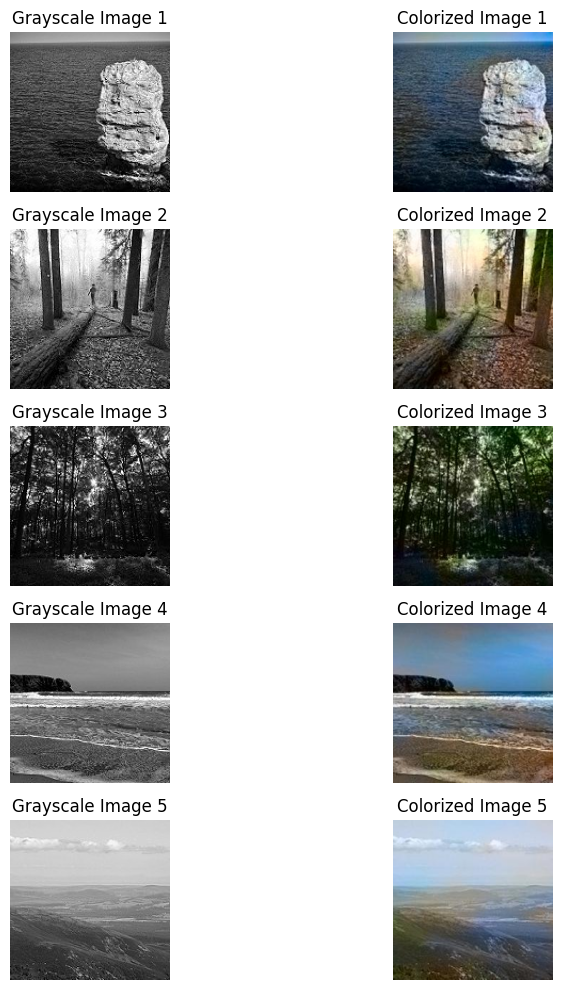

In [23]:

testpath = '/content/test/test/'
colorized_path = '/content/test/test/'
gray_files = ['t2.jpg', 't1.jpg', 't3.jpg', 't5.jpg', 't4.jpg']
colorized_files = [f'colorized_{i}.jpg' for i in range(len(gray_files))]

plt.figure(figsize=(10, 2 * len(gray_files)))
for idx, (gray_file, colorized_file) in enumerate(zip(gray_files, colorized_files)):

    gray_img = img_to_array(load_img(os.path.join(testpath, gray_file)))
    gray_img = rgb2gray(gray_img)  # Convert to grayscale if necessary

    # Load colorized image
    color_img = img_to_array(load_img(os.path.join(colorized_path, colorized_file)))

    # Display grayscale image
    plt.subplot(len(gray_files), 2, idx * 2 + 1)
    plt.imshow(gray_img, cmap='gray')
    plt.axis('off')
    plt.title(f'Grayscale Image {idx + 1}')

    # Display colorized image
    plt.subplot(len(gray_files), 2, idx * 2 + 2)
    plt.imshow(color_img.astype('uint8'))
    plt.axis('off')
    plt.title(f'Colorized Image {idx + 1}')

plt.tight_layout()
plt.show()
